### Libraries

In [1]:
# !pip install wordcloud
# !pip install prettytable

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import time as tm
from datetime import date
import pickle
import copy

import sqlite3
from tabulate import tabulate

from wordcloud import WordCloud

from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, MaxAbsScaler

from scipy.sparse import hstack
import scipy.stats

%matplotlib inline
sns.set_style("whitegrid")
# plt.style.use("fivethirtyeight")
plt.style.use(['seaborn-v0_8-deep'])

import warnings
warnings.filterwarnings("ignore")

### Data import

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.text.head(20)

0     Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7     I'm on top of the hill and I can see a fire in...
8     There's an emergency evacuation happening now ...
9     I'm afraid that the tornado is coming to our a...
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                       What's up man?
16                                        I love fruits
17                                     Summer is

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Exploratory Data Analysis

In [5]:
baseline = df_train.value_counts('target', normalize=True)
baseline

target
0    0.57034
1    0.42966
dtype: float64

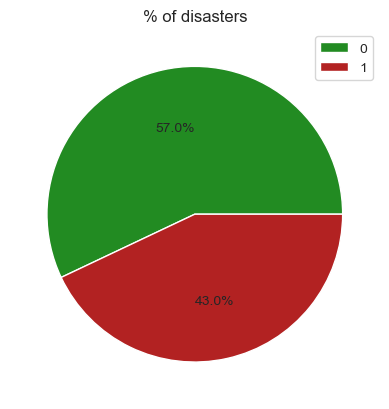

In [6]:
plt.pie(x=baseline, colors=['forestgreen', 'firebrick'], autopct='%1.1f%%')
plt.legend(labels=baseline.index)
plt.title('% of disasters')
plt.show()

__Disasters occur in 43% cases.__

### Location

In [7]:
df_train['location'] = df_train['location'].str.upper()
df_train['location'] = df_train['location'].fillna('N/A')

In [8]:
locations = df_train.value_counts('location').to_frame().reset_index()
locations.columns = ['location', 'number']
locations

,location,number
0,N/A,2533
1,USA,104
2,NEW YORK,75
3,UNITED STATES,50
4,LONDON,49
...,...,...
3229,"HALIFAX, NS, CANADA",1
3230,HALTON REGION,1
3231,"HALTON, ONTARIO",1
3232,"HAMBURG, DE",1


In [9]:
multi_locations = locations[locations['number']!=1]
multi_locations

,location,number
0,N/A,2533
1,USA,104
2,NEW YORK,75
3,UNITED STATES,50
4,LONDON,49
...,...,...
523,ALL AROUND THE WORLD,2
524,"19.600858, -99.047821",2
525,VIETNAM,2
526,MO.CITY,2


In [10]:
loc_na = locations[locations['location']=='N/A']['number'][0]
loc1 = locations[(locations['number']==1) & (locations['location']!='N/A')]['number'].count()
loc1_10 = locations[(locations['number']>1)&(locations['number']<=10)]['number'].count()
loc_more10 = locations[locations['number']>10]['number'].count()
sizes = [loc_na, loc1, loc1_10, loc_more10]
labels= ['N/A', '1', '2-10', 'more than 10']

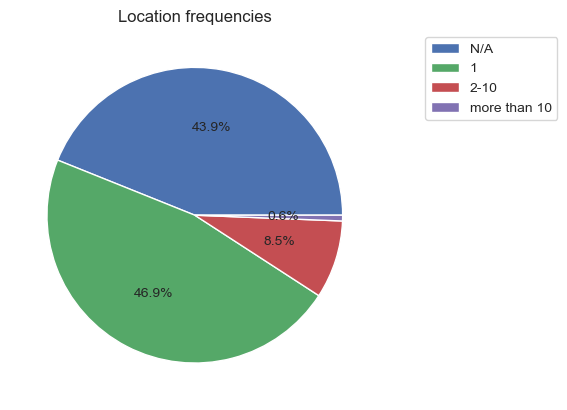

In [11]:
plt.pie(sizes, autopct='%1.1f%%')
plt.legend(labels=labels, loc='upper right', bbox_to_anchor=(1.5, 1))
plt.title('Location frequencies')
plt.show()

__Almost 44% of tweets have no specified location, 47% have unique location (appears in exactly one tweet) and only 9% of tweets have location which repeats in multiple tweets. Let's see if we can unify some of them to obtain any predictive ability for modeling.__ 

__First we, will replace some popular abbreviations or alternative names into consistent pattern__

__To do it we will first prepare dictionary__

In [12]:
names_to_map = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming',
    'AB': 'Alberta',
    'BC': 'British Columbia',
    'MB': 'Manitoba',
    'NB': 'New Brunswick',
    'NL': 'Newfoundland and Labrador',
    'NS': 'Nova Scotia',
    'NT': 'Northwest Territories',
    'NU': 'Nunavut',
    'ON': 'Ontario',
    'PE': 'Prince Edward Island',
    'QC': 'Quebec',
    'SK': 'Saskatchewan',
    'YT': 'Yukon',
    'UK': 'UNITED KINGDOM',
    'ENGLAND': 'UNITED KINGDOM',
    'UNITED STATES': 'USA',
    'US': 'USA',
    'NYC': 'NEW YORK',
    'NEW YORK CITY': 'NEW YORK',
    'WORLDWIDE': 'EARTH',
    'EVERYWHERE': 'EARTH',
    'WORLD': 'EARTH'
}

names_to_map = {key: value.upper() for key, value in names_to_map.items()}

__One approach to location feature could be to determine the actual location at set level e.g. continent/country/state/city or even create few features. However this would require lot of manual work (prelude to that approach was creating dictionary with abbreviations and alternative names of places).__

__Therefore we decide to take another approach. We will treat this feature similar to main feature of dataset - 'text'. We won't manualy look for patterns. Instead we will process this feature to perform vectorization on later stage.__

In [13]:
def loc_processing(location):
    
    stemmer = PorterStemmer()
    
# if there are multiple locations they are usually separated by commas. In such cases we will map values with those in
# dictionary prepared before. We are doing this before removing punctuation

    location = ' '.join([names_to_map.get(loc, loc) for loc in location.split(',')])
    
    punctuation = '[' + re.escape(string.punctuation) + ']'
    location = re.sub(punctuation, '', location)

# we will tokenize locations in order to perform stemming but before that we will perform once again map values from
# dictionary (after punctuation removal)

    tokens = word_tokenize(location)
    tokens = [names_to_map.get(token, token) for token in tokens]
    
    tokens = [stemmer.stem(word.lower()) for word in tokens]
    
    return ' '.join(tokens)

In [14]:
df_train['location_processed'] = df_train['location'].apply(loc_processing)

In [15]:
df_train.sample(10)

,id,keyword,location,text,target,location_processed
811,1178,blight,N/A,@jake_blight @WeAlIlKnowA you cunt,0,na
3704,5269,fear,CARREGADO,I didn`t want to hurt you but the fear drove m...,0,carregado
5157,7356,obliterate,PURFLEET,Whereas Jez will obliterate the national debt ...,1,purfleet
6527,9337,survive,N/A,#Autoinsurance industry clueless on driverless...,1,na
5719,8162,rescuers,LONDON,VIDEO: 'We're picking up bodies from water': R...,1,london
5108,7287,nuclear%20disaster,N/A,573 deaths have been certified by the Governme...,1,na
6011,8584,screams,5-FEB,When you go to a concert and someone screams i...,1,5feb
937,1354,blown%20up,NOWHERE ISLANDS/SMASH MANOR,@TheBoyOfMasks 'Thanks again for letting me st...,0,nowher islandssmash manor
7202,10317,weapon,"CT, USA",@Camilla_33 @CrayKain Hate to shatter your del...,0,connecticut usa
6097,8706,sinking,N/A,?that horrible sinking feeling when youÛªve b...,0,na


__In order to perform the same transformation on test set, we will prepare function that consists all trasformations performed on training set__

In [16]:
def location_transformation(df, feature):
    
    df[feature] = df[feature].str.upper()
    df[feature] = df[feature].fillna('N/A')
    
    name = feature + '_processed'
    
    df[name] = df[feature].apply(loc_processing)

__Let's see if these transformations gave any results.__

In [17]:
locations_processed = df_train.value_counts('location_processed').to_frame().reset_index()
locations_processed.columns = ['location', 'number']
loc_na = locations_processed[locations_processed['location']=='na']['number'][0]
loc1 = locations_processed[(locations_processed['number']==1) & (locations_processed['location']!='N/A')]['number'].count()
loc1_10 = locations_processed[(locations_processed['number']>1)&(locations_processed['number']<=10)]['number'].count()
loc_more10 = locations_processed[locations_processed['number']>10]['number'].count()
sizes = [loc_na, loc1, loc1_10, loc_more10]
labels= ['N/A', '1', '2-10', 'more than 10']

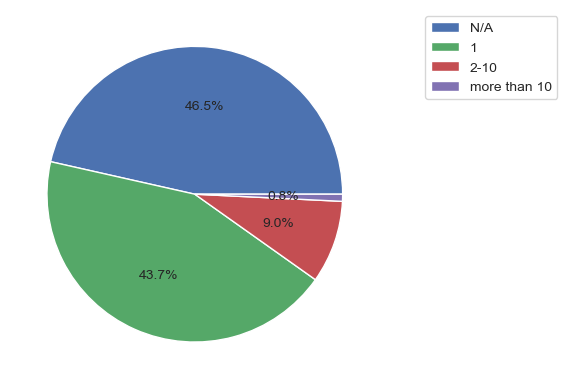

In [18]:
plt.pie(sizes, autopct='%1.1f%%')
plt.legend(labels=labels, loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

__Not much... These feature won't have strong predictive power.__

### Keyword

In [19]:
df_train.value_counts('keyword')

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Length: 221, dtype: int64

__Keywords are much more consistent than location, which is promising in order to create a model including this feature.__

In [20]:
df_train['keyword'] = df_train['keyword'].str.lower()
df_train['keyword'] = df_train['keyword'].fillna('N/A')

In [21]:
df_train['keyword'].sample(20)

2621      destruction
395             arson
3527       eyewitness
6835          trapped
6107          sinking
5678          rescued
742          bleeding
5919         screamed
5947        screaming
4090             hail
4542          injured
7                 N/A
3312         evacuate
333        armageddon
4026    forest%20fire
3255         engulfed
3579            fatal
5270      oil%20spill
2010           damage
454            attack
Name: keyword, dtype: object

__As we can see there is pattern that words are separated with '%20'. We will replace it with space and also remove stopwords (there are some: e.g. 'on'). Lastly we will stem words so we can classify similar words together.__ 

In [22]:
def keyword_processing(keyword):
    
    stemmer = PorterStemmer()
        
    keyword = re.sub(r'%20', ' ', keyword) 
    
    tokens = word_tokenize(keyword)
    tokens = [stemmer.stem(token.lower()) for token in tokens if token not in stopwords.words('english')]
    
    return ' '.join(tokens)

In [23]:
df_train['keyword_processed'] = df_train['keyword'].apply(keyword_processing)

__Let's take a look at most popular keywords (actually stems of keywords) in visual for of Word Cloud.__

In [24]:
text = ' '.join(df_train['keyword_processed']) # one long string is required to generate WordCloud object

In [25]:
wordcloud = WordCloud(width=800, 
                      height=400, 
                      max_words=200 , 
                      background_color='white', 
                      collocations=False, 
                      colormap='seismic').generate(text)

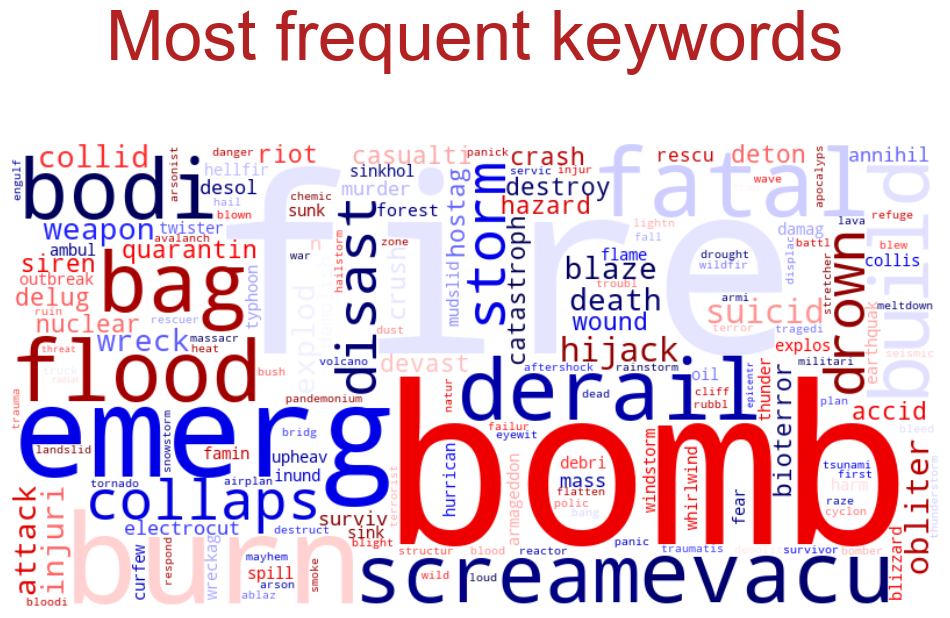

In [26]:
plt.figure(figsize=(12,8))
plt.title('Most frequent keywords\n', fontsize=50, color='firebrick')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
df_train['keyword_processed'].value_counts()

fatal           120
derail          112
evacu           112
flood           109
bodi bag        107
               ... 
bush fire        25
war zone         24
epicentr         12
threat           11
radiat emerg      9
Name: keyword_processed, Length: 167, dtype: int64

__Fire is biggest word in Work Cloud but is not the most popular keyword because it appears in several contexts.__

In [28]:
df_train[df_train['keyword_processed'].str.contains('fire')]['keyword_processed'].value_counts()

forest fire    51
fire           38
build fire     33
fire truck     33
wild fire      31
bush fire      25
Name: keyword_processed, dtype: int64

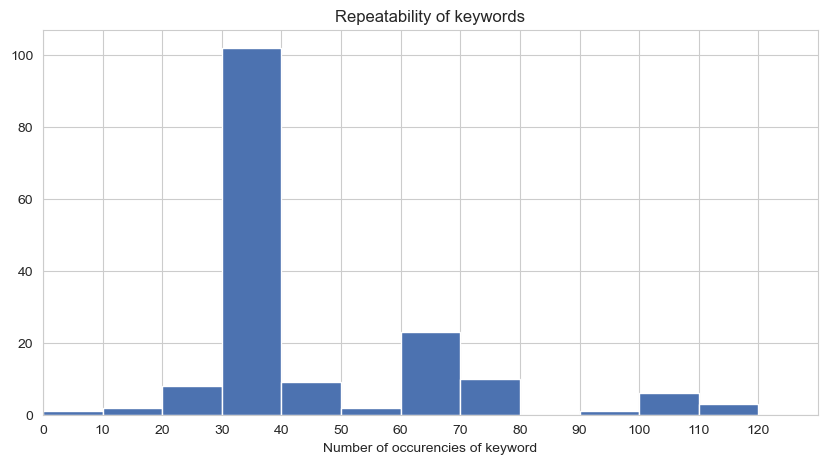

In [29]:
plt.figure(figsize=(10,5))
plt.title('Repeatability of keywords')
plt.hist(df_train['keyword_processed'].value_counts(), bins=range(0,130,10))
plt.xlabel('Number of occurencies of keyword')
plt.xticks(range(0,130,10))
plt.xlim(0,130)
plt.show()

__Vast majority of keywords appear in 20 or more tweets which is necessary for it's predictive power. Let's see if keywords are informative - if occurence of some keywords correlate with disasters or their absence.__

In [30]:
informative_keywords =\
df_train.groupby('keyword_processed')['target', 'id']\
        .agg({'target' : 'mean', 'id' : 'count'})\
        .sort_values(by='target', ascending=False)\
        .reset_index().rename(columns={'keyword_processed':'keyword', 'target':'% of disaster', 'id':'count'})

In [31]:
informative_keywords

,keyword,% of disaster,count
0,wreckag,1.000000,39
1,debri,1.000000,37
2,outbreak,0.975000,40
3,oil spill,0.973684,38
4,typhoon,0.973684,38
...,...,...,...
162,blew,0.060606,33
163,panick,0.060606,33
164,traumatis,0.057143,35
165,ruin,0.027027,37


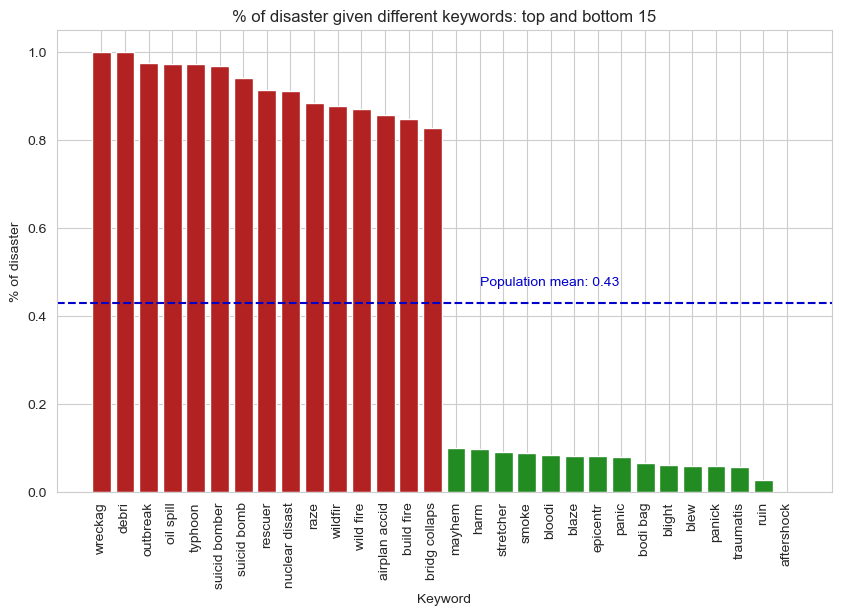

In [32]:
n=15 # parametr to choose how much keywords from top and bottom we want to see
top_informative_keywords = pd.concat([informative_keywords[:n], informative_keywords[-n:]])
color = n*['firebrick'] + n*['forestgreen']

plt.figure(figsize=(10,6))
plt.bar(x=top_informative_keywords['keyword'], 
        height=top_informative_keywords['% of disaster'],
        color=color)
plt.axhline(baseline[1], linestyle='--', color='mediumblue')
plt.text(x=n+1, y=baseline[1]+0.04, s=f'Population mean: {round(baseline[1],2)}', color= 'mediumblue')
plt.xlabel('Keyword')
plt.ylabel('% of disaster')
plt.xticks(rotation=90)
plt.title(f'% of disaster given different keywords: top and bottom {n}')
plt.show()

__As we can see, keywords have very strong informative power. What's more, many of them are counter intuitive. For example, words such as panic, smoke, harm etc have very low disaster rate. It's interesting that similar words such as ruins and debris are on the opposite sides of the scale.__

__In order to perform the same transformation on test set, we will prepare function that consists all trasformations performed on training set__

In [33]:
def keyword_transformation(df, feature):
    
    df[feature] = df[feature].str.lower()
    df[feature] = df[feature].fillna('N/A')
    
    name = feature + '_processed'
    
    df[name] = df[feature].apply(keyword_processing)

### Text

In [34]:
df_train['text'] = df_train['text'].str.lower()

In [35]:
df_train['tweet_len'] = df_train['text'].apply(len)

In [36]:
df_train

,id,keyword,location,text,target,location_processed,keyword_processed,tweet_len
0,1,N/A,N/A,our deeds are the reason of this #earthquake m...,1,na,n/a,69
1,4,N/A,N/A,forest fire near la ronge sask. canada,1,na,n/a,38
2,5,N/A,N/A,all residents asked to 'shelter in place' are ...,1,na,n/a,133
3,6,N/A,N/A,"13,000 people receive #wildfires evacuation or...",1,na,n/a,65
4,7,N/A,N/A,just got sent this photo from ruby #alaska as ...,1,na,n/a,88
...,...,...,...,...,...,...,...,...
7608,10869,N/A,N/A,two giant cranes holding a bridge collapse int...,1,na,n/a,83
7609,10870,N/A,N/A,@aria_ahrary @thetawniest the out of control w...,1,na,n/a,125
7610,10871,N/A,N/A,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,na,n/a,65
7611,10872,N/A,N/A,police investigating after an e-bike collided ...,1,na,n/a,137


__Let's take a look how lenght of tweet is corresponding with real disaster.__

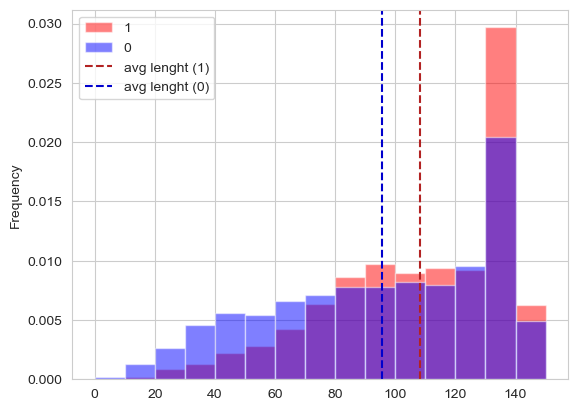

In [37]:
avg_1 = df_train[df_train['target']==1].tweet_len.mean()
avg_0 = df_train[df_train['target']==0].tweet_len.mean()

bins = range(0,df_train['tweet_len'].max(),10)
df_train[df_train['target']==1].tweet_len.plot(kind='hist',density=True,color='red',alpha=0.5, bins=bins, label='1')
df_train[df_train['target']==0].tweet_len.plot(kind='hist',density=True,color='blue',alpha=0.5, bins=bins, label='0')
plt.axvline(avg_1, ls='--', label='avg lenght (1)', color='firebrick')
plt.axvline(avg_0, ls='--', label='avg lenght (0)', color='mediumblue')
plt.legend()
plt.show()

__It can be seen that tweets announcing disaster are usually longer than others.__

__Let's prepare a function for text processing. It will remove punctuation, hyperlinks and stem words. We will also prepare functionality that will let us unify synonym words into one unified word.__

__After that it will invert tokens into strings in order for vectization on the later stage.__

In [38]:
def get_synonyms(word):
    
    synonyms = []
    
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    
    return synonyms

In [39]:
def text_processing(text, with_synonyms=True):
    
    stemmer = PorterStemmer()

    punctuation = '[' + re.escape(string.punctuation) + ']'
    text = re.sub(r'http\S+', '', text)
    text = re.sub(punctuation, '', text)
    
    tokens = word_tokenize(text) 
    
    tokens = [stemmer.stem(token.lower()) for token in tokens if token not in stopwords.words('english')]
    
    if with_synonyms:
        
        new_tokens = []
    
        for token in tokens:
            synonyms = get_synonyms(token)

            if synonyms:
                new_tokens.append(synonyms[0].lower())
            else:
                new_tokens.append(token)
        
        return ' '.join(new_tokens)
        
    else:
  
        return ' '.join(tokens)

In [40]:
df_train['text_processed'] = df_train['text'].apply(text_processing)

In [41]:
df_train['text_processed_no_syn'] = df_train['text'].apply(lambda x: text_processing(x, with_synonyms=False))

__We will prepare tokens in order to create new feature - number of tokens in tweet__

In [42]:
df_train['tokens'] = df_train['text_processed'].str.split(' ')

In [43]:
df_train['tokens_no_syn'] = df_train['text_processed_no_syn'].str.split(' ')

In [44]:
df_train['number_tokens'] = df_train['tokens'].apply(len)

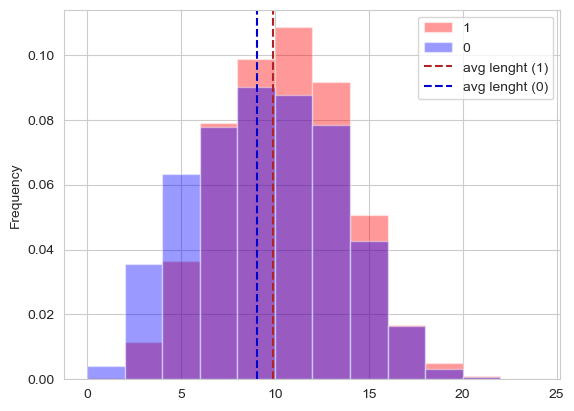

In [45]:
avg_1 = df_train[df_train['target']==1].number_tokens.mean()
avg_0 = df_train[df_train['target']==0].number_tokens.mean()

bins = range(0,df_train['number_tokens'].max(),2)
df_train[df_train['target']==1].number_tokens.plot(kind='hist',density=True,color='red',alpha=0.4, bins=bins, label='1')
df_train[df_train['target']==0].number_tokens.plot(kind='hist',density=True,color='blue',alpha=0.4, bins=bins, label='0')
plt.axvline(avg_1, ls='--', label='avg lenght (1)', color='firebrick')
plt.axvline(avg_0, ls='--', label='avg lenght (0)', color='mediumblue')
plt.legend()
plt.show()

__Similar realtionship as in the number of characters appears in number of words.__

__Let's take a look at most popular words.__

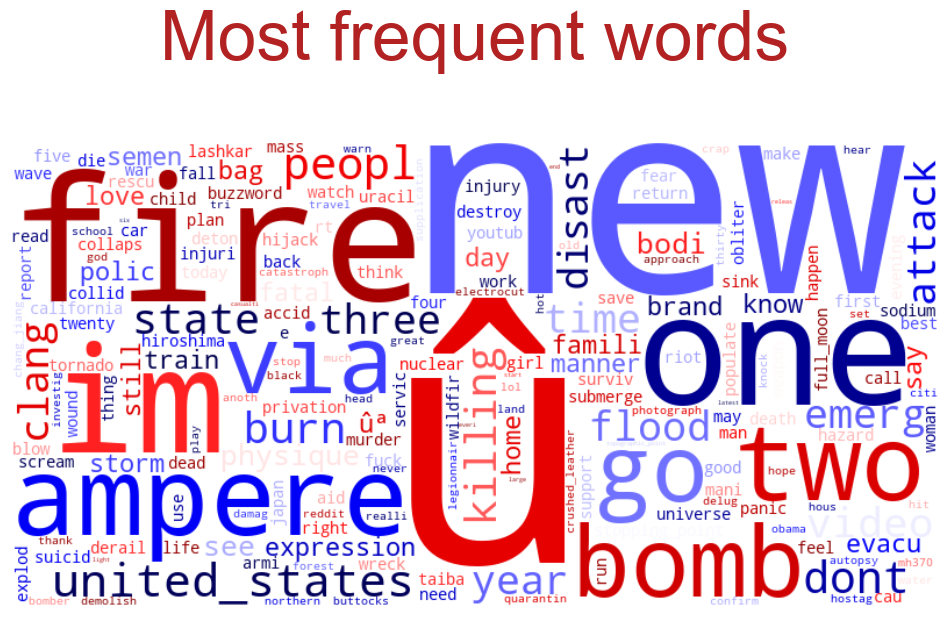

In [46]:
text = ' '.join(df_train['text_processed'])

wordcloud = WordCloud(width=800, 
                      height=400, 
                      max_words=200 , 
                      background_color='white', 
                      collocations=False, 
                      colormap='seismic').generate(text)

plt.figure(figsize=(12,8))
plt.title('Most frequent words\n', fontsize=50, color='firebrick')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [47]:
def count_freqs(tweet, freq_dict):

    for word in tweet:

        if word in freq_dict:
            freq_dict[word] += 1
        else:
            freq_dict[word] = 1

In [48]:
freqs = {}
df_train['tokens'].apply(lambda x: count_freqs(x, freqs))
word_count = pd.DataFrame(freqs.items(), columns=['word', 'count'])

In [49]:
word_count.sort_values(by='count', ascending=False)

,word,count
28,get,440
8,fire,418
124,like,408
57,im,300
304,ampere,298
...,...,...
8112,rs40000cr,1
8113,lifelin,1
8114,fci,1
8115,3612,1


In [50]:
freqs_no_syn = {}
df_train['tokens_no_syn'].apply(lambda x: count_freqs(x, freqs_no_syn))
word_count_no_syn = pd.DataFrame(freqs_no_syn.items(), columns=['word', 'count'])
word_count_no_syn.sort_values(by='count', ascending=False)

,word,count
126,like,408
8,fire,357
78,get,311
57,im,300
307,amp,298
...,...,...
7339,3945,1
7340,zaire2005,1
7341,specialguest,1
7342,crapgam,1


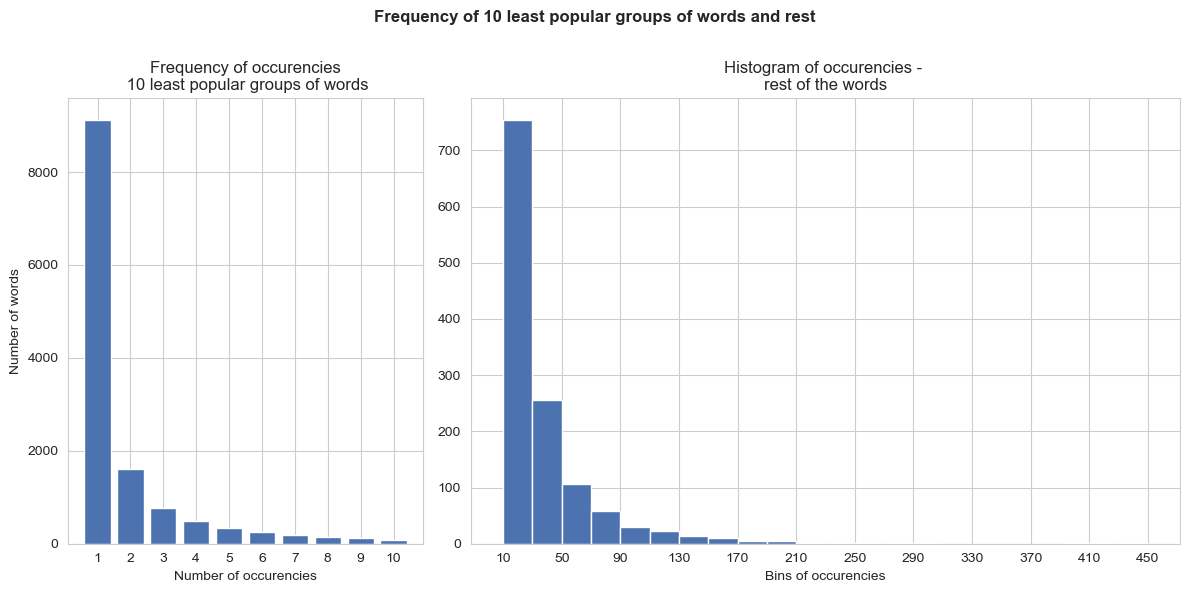

In [51]:
n = 10 # parameter to control how much least popular groups we want to see

fig, ax = plt.subplots(1,2, figsize=(12,6), gridspec_kw={'width_ratios': [10+n, 50-n]})
plt.suptitle(f"Frequency of {n} least popular groups of words and rest\n", weight='bold')

rare_words = word_count[word_count['count']<=n]['count'].value_counts()

ax[0].bar(rare_words.index, rare_words)
ax[0].set_title(f"Frequency of occurencies\n {n} least popular groups of words", fontsize=12)
ax[0].set_xticks(range(1,n+1,1))
ax[0].set_xlabel('Number of occurencies')
ax[0].set_ylabel('Number of words')

multiple_words = word_count[word_count['count']>n]

ax[1].hist(multiple_words['count'], bins=range(n,max(multiple_words['count'])+20, 20))
ax[1].set_title(f'Histogram of occurencies - \nrest of the words', fontsize=12)
ax[1].set_xticks(range(n,max(multiple_words['count'])+20, 40))
ax[1].set_xlabel('Bins of occurencies')
plt.tight_layout()
plt.show()

__In order to perform the same transformation on test set, we will prepare function that consists all trasformations performed on training set__

In [52]:
def text_transformation(df, feature):
    
    df[feature] = df[feature].str.lower()
    
    df['tweet_len'] = df_train[feature].apply(len)
    
    name = feature + '_processed'
    name_no_syn = feature + '_processed_no_syn'
       
    df[name] = df[feature].apply(text_processing)
    df[name_no_syn] = df[feature].apply(lambda x: text_processing(x, with_synonyms=False))
    
    df['tokens'] = df['text_processed'].str.split(' ')
    df['tokens_no_syn'] = df[name_no_syn].str.split(' ')
    df['number_tokens'] = df['tokens'].apply(len)

### Preparing test set

In [53]:
df_test = pd.read_csv('test.csv')

__We will perform exactly the same transformations as we did on the training set__

In [54]:
location_transformation(df_test, 'location')
keyword_transformation(df_test, 'keyword')
text_transformation(df_test, 'text')

In [55]:
df_test.head(2)

,id,keyword,location,text,location_processed,keyword_processed,tweet_len,text_processed,text_processed_no_syn,tokens,tokens_no_syn,number_tokens
0,0,N/A,N/A,just happened a terrible car crash,na,n/a,69,happen terribl car clang,happen terribl car crash,"[happen, terribl, car, clang]","[happen, terribl, car, crash]",4
1,2,N/A,N/A,"heard about #earthquake is different cities, s...",na,n/a,38,hear earthquak differ citi stay safe everyon,heard earthquak differ citi stay safe everyon,"[hear, earthquak, differ, citi, stay, safe, ev...","[heard, earthquak, differ, citi, stay, safe, e...",7


## Vectorization

__We will perform vectoriaztion multiple times in different configurations. Therefore we will prepare proper function.__

In [56]:
# As arguments, user have to pass 

#    - df - selected feature of df
#    - vectorizer (empty for training set and fitted for test set)
#    - train_or_test - declaration if it's 'train' or 'test' set

def vectorization(df, vectorizer, train_or_test):
       
# the function can work in two modes - for training set (fit_transform) and for test set (only transform).
# In both cases it vectorizes feature
    
    if train_or_test == 'train':
        vectorized = vectorizer.fit_transform(df)
        
    elif train_or_test == 'test':
        vectorized = vectorizer.transform(df)
    
    else:
        return 'You have to put "train" or "test" into train_or_test argument'
    
# The function returns vectorized which is a sparse matrix and fitted_vectorizer for later use (on test set)
        
    return vectorized, vectorizer

In [57]:
# As I previously mention, we will probably work on more than one vectorized feature. That's why we need tool to automate
# concatenation of sparse matrixes. Therefore we will create function with 'vectorization' fuction  nested inside.
# Arguments are very similar to previous function's but now features and vectorizers have to be passed in lists 
# (in the right order: pairs of feature-vectorizer).
# Function below will work even with lists containing 1 features so to keep code consistent we will use this function
# in all cases (even if we use only 1 feature)

def concat_vectorize(df, columns_list, vectorizers_list, train_or_test):
   
    vectorized_features =[]
    fitted_vectorizers = []

    for column, vectorizer in zip(columns_list, vectorizers_list):
        
        vectorized_feature, fitted_vectorizer = vectorization(df[column], vectorizer, train_or_test)
        
        vectorized_features.append(vectorized_feature)
        fitted_vectorizers.append(fitted_vectorizer)
        
    X_vectorized = hstack(vectorized_features)
    
    return X_vectorized, fitted_vectorizers

## Modeling

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=23)

__We will prepare proper functions to automate process of comparing different models, features and vectorizers.__

In [59]:
# As arguments, user have to pass

# models_list - list of models to compare
# X - data (vectorized)
# y - target label

def compare_models(models_list, X, y):
    
    results_list = []
    
    print(f'Cross validating {len(models_list)} models in progress...\n')

    for idx, model in enumerate(models_list):
               
        results = cross_validate(model, X, y, scoring='f1', cv=kf, return_estimator=True)
        
        best_index = np.argmax(results['test_score'])
        best_score = results['test_score'][best_index]
        avg_score = results['test_score'].mean()
        avg_time = results['fit_time'].mean()
        best_model = results['estimator'][best_index]

        new = {'model' : best_model,
               'best_score' : round(best_score,4),                        
               'avg_score' : round(avg_score,4),
               'time' : round(avg_time,1)}
        
        results_list.append(new)
        

        print(f'{idx+1}/{len(models_list)} - model: {str(model)}, average F1-score: {round(avg_score,4)}, time: {round(avg_time,1)}')
            
    print('')

    return pd.DataFrame(results_list)

# Function will return DataFrame of model and its results

In [118]:
# This function is expanding the previous one with functionality to compare models on different features and vectorizers
# There are parameters: 'mode', 'params' and 'n_iter' that will be used on later stage of the project. By now we will 
# operate only in 'standard' mode which uses 'compare_models' function written above

# as input we have to provide function with training dataset and lists of columns, vectorizers and models.
# !!! Even if we give only one argument in any of them we have to put in list

def feature_vec_selection(df, feature_selection, vectorizers, models, 
                          mode='standard', params=None, n_iter=100):

    y = df['target']

    results = pd.DataFrame(columns=['model', 'best_score', 'avg_score', 'time', 
                                    'temp_vec_id', 'vectorizer', 'features'])

    no_iter = len(feature_selection) * len(vectorizers)
    print('!!! START!!!\n')
    print(f'{len(feature_selection)} sets of features\n' 
          f'{len(vectorizers)} vectorizers\n'
          f'This gives us {no_iter} iterations\n')
    print('-------------------------------------------------------')
    
    feature_count = 1
      
    for columns in feature_selection:
        
        vec_count = 1

        for vectorizer in vectorizers:

            print(f'{feature_count}/{len(feature_selection)} Current Feature selection: {columns}') 
            print(f'{vec_count}/{len(vectorizers)} Current Vectorizer: {vectorizer}\n') 
            
            # we have to duplicate vectorizer to be compatible with number of features
            vectorizers_list = [copy.deepcopy(vectorizer) for _ in columns]

            X, fitted_vectorizers = concat_vectorize(df, columns, vectorizers_list, 'train')
            
            # this is condition that will be used on later stage of the project
            if mode == 'hyperparameters':
                new_results = hyperparameters(models, params, X, y, n_iter)
            # in 'standard' mode function uses else condition below
            else:
                new_results = compare_models(models, X, y)
            
            # it assigns list of vectorizers its unique temporary id (later it will be replaced by permanent database ID)
            vec_id = f'{np.random.randint(0, 100000):05d}'

            new_results['temp_vec_id'] = vec_id
            # assigning same vectorizers and features to all results from current iteration
            new_results['vectorizer'] = [fitted_vectorizers] * new_results.shape[0] 
            new_results['features'] = [columns] * new_results.shape[0]

            results = pd.concat([results, new_results], axis=0)
            
            print('-------------------------------------------------------\n')
            
            vec_count += 1
            
        print('*******************************************************\n')
        
        feature_count += 1

    print('FINISHED!')
    
    return results

__Now we can select several features, vectorizers and models to check which are the best.__

In [61]:
feature_selection = [
    ['text_processed'],
    ['text_processed', 'keyword_processed'],
    ['text_processed', 'keyword_processed', 'location_processed'],
    ['text_processed_no_syn'],
    ['text_processed_no_syn', 'keyword_processed'],
    ['text_processed_no_syn', 'keyword_processed', 'location_processed']
]

vectorizers = [
    CountVectorizer(),
    CountVectorizer(ngram_range=(1,2)),
    CountVectorizer(ngram_range=(1,3)),
    CountVectorizer(ngram_range=(1,4)),
    TfidfVectorizer(),
    TfidfVectorizer(ngram_range=(1,2)),
    TfidfVectorizer(ngram_range=(1,3)),
    TfidfVectorizer(ngram_range=(1,4))
]

models_list = [LogisticRegression(), 
               MultinomialNB(),
               KNeighborsClassifier(),
               XGBClassifier()
]

In [120]:
# results = feature_vec_selection(df_train, feature_selection, vectorizers, models_list)

!!! START!!!

2 sets of features
2 vectorizers
This gives us 4 iterations

-------------------------------------------------------
1/2 Current Feature selection: ['text_processed']
1/2 Current Vectorizer: CountVectorizer()

Cross validating 2 models in progress...

1/2 - model: LogisticRegression(), average F1-score: 0.7451, time: 0.2
2/2 - model: MultinomialNB(), average F1-score: 0.755, time: 0.0

-------------------------------------------------------

1/2 Current Feature selection: ['text_processed']
2/2 Current Vectorizer: TfidfVectorizer()

Cross validating 2 models in progress...

1/2 - model: LogisticRegression(), average F1-score: 0.7297, time: 0.2
2/2 - model: MultinomialNB(), average F1-score: 0.7341, time: 0.0

-------------------------------------------------------

*******************************************************

2/2 Current Feature selection: ['text_processed', 'keyword_processed']
1/2 Current Vectorizer: CountVectorizer()

Cross validating 2 models in progress..

## SQL DB

__We will test hundreds of different models in this task. To keep them organized they will be stored in SQL Database. Next steps will be creating tables in DB and preparing functions to operate it.__

__Our choice for this task will be sqlite3 beacuse its the simpliest one but still sufficient for our purposes.__

__Database will contain three tables: models, features, vectorizers. Because of the many-to-one relationship between model and vectorizers and features, model table foreign keys will refer to others primary keys.__

### Creating Tables

In [63]:
create_vectorizers_table = """
CREATE TABLE IF NOT EXISTS vectorizers (
vectorizer_id INTEGER PRIMARY KEY AUTOINCREMENT,
vectorizer TEXT NOT NULL,
params TEXT
);
"""

create_features_table = """
CREATE TABLE IF NOT EXISTS features (
features_id INTEGER PRIMARY KEY AUTOINCREMENT,
number_features INTEGER NOT NULL,
features TEXT NOT NULL
);
"""

create_models_table = """
CREATE TABLE IF NOT EXISTS models (
model_id INTEGER PRIMARY KEY AUTOINCREMENT,
date DATE NOT NULL,
model_name TEXT NOT NULL,
params TEXT,
best_score FLOAT,
avg_score FLOAT NOT NULL,
vectorizer_id INTEGER NOT NULL,
features_id INTEGER NOT NULL,
submission BOOL,
test_score FLOAT,
FOREIGN KEY (vectorizer_id) REFERENCES vectorizers (vectorizer_id),
FOREIGN KEY (features_id) REFERENCES features (features_id)
);
"""

In [64]:
# Below code is commented because it was performed only once while creating tables

# with sqlite3.connect('models_db.sqlite') as connection:
#     cursor = connection.cursor()
#     cursor.execute(create_vectorizers_table)
#     cursor.execute(create_features_table)
#     cursor.execute(create_models_table)
#     connection.commit()

__We will also prepare function to execute simple queries in database. However in order to perform deepened analysis later on, we will upload database to DataFrame because of it's functionality and also aesthetic reasons. An appropriate function will be created at a later stage__

In [65]:
def sql_select_query(user_query):
    
    with sqlite3.connect('models_db.sqlite') as connection:
        
        cursor = connection.cursor()

        query = cursor.execute(user_query).fetchall()

        columns = [description[0] for description in cursor.description]

        print(tabulate(query, headers=columns, tablefmt="pretty"))

In [66]:
user_query = """
SELECT * FROM models
"""

sql_select_query(user_query)

+----------+------------+----------------------+--------------------------------------------------------------------------------+------------+-----------+---------------+-------------+------------+------------+
| model_id |    date    |      model_name      |                                     params                                     | best_score | avg_score | vectorizer_id | features_id | submission | test_score |
+----------+------------+----------------------+--------------------------------------------------------------------------------+------------+-----------+---------------+-------------+------------+------------+
|    1     | 2023-12-27 |  LogisticRegression  |                                                                                |   0.757    |  0.7451   |       1       |      1      |            |            |
|    2     | 2023-12-27 |    MultinomialNB     |                                                                                |   0.7627   |   0.755   |  

### Adding results to db

__In order to automate adding results (DataFrame) to DB we have to prepare proper functions. Due to tables specifity there are going to be three functions.__

In [67]:
def add_features_to_db(cursor, results):
    
    number_features = results['features'].drop_duplicates().apply(len).to_list()
    # As we only want to add every set of features once, we will drop all duplicates
    unique_features = results['features'].drop_duplicates().apply(lambda row: ', '.join(row)).to_list()


    add_features_to_db = """
    INSERT INTO
        features (number_features, features)
    VALUES
        (?, ?);
    """

    features_to_insert = []
    number_to_insert = []

    for features, number in zip(unique_features, number_features):
        
        # this query checks if this set of feature is already in database
        check_query = "SELECT COUNT(*) FROM features WHERE features = ?"
        cursor.execute(check_query, (features,))
        
        # appending set to list which will be added to database happens only if it's not in database yet
        if cursor.fetchone()[0] == 0: 
            features_to_insert.append(features)
            number_to_insert.append(number)
    
    # if our appending list isn't empty function will execute query
    if len(features_to_insert) != 0:

        features_data = list(zip(number_to_insert, features_to_insert))
        cursor.executemany(add_features_to_db, features_data)

In [68]:
def add_vectorizers_to_db(cursor, results):

    add_vectorizer_to_db = """
    INSERT INTO
        vectorizers (vectorizer, params)
    VALUES
        (?, ?);
    """
    
    # As we only want to add every vectorizers list once, we will drop all duplicates
    unique_vec_df = results.drop_duplicates('temp_vec_id')

    id_dict = {}

    # function will itterate over unique vectorizers
    for index, row in unique_vec_df.iterrows():

        vectorizer = row['vectorizer']
        
        # in database we want only name of vectorizer not whole list
        vectorizer_str = str(row['vectorizer'][0])
        # everything before the bracket is vectorizer's name and after that are it's params
        vectorizer_name = vectorizer_str[:vectorizer_str.find('(')]
        vectorizer_param = vectorizer_str[vectorizer_str.find('(')+1:-1]

        cursor.execute(add_vectorizer_to_db, (vectorizer_name, vectorizer_param))
        # here, we create a dict to replace vectorizer's temporary id with new id compatible with DB 
        # (consecutive numbers in the order they were added to the database)
        db_id = cursor.lastrowid
        temp_id = row['temp_vec_id']
        id_dict[temp_id] = db_id
        
        # Lastly, we save vectorizer as pickle file where it's new ID is name of the file in '/vectorizers' folder
        vec_name = 'vectorizers/' + str(db_id)
        pickle.dump(vectorizer, open(vec_name, 'wb'))    

    # function returns id dictionary in order to assign correct models to vectorizers
    return id_dict

In [69]:
def add_models_to_db(cursor, results, id_dict):

    add_model_to_db = """
    INSERT INTO
        models (date, model_name, params, best_score, avg_score, vectorizer_id, features_id)
    VALUES
        (?, ?, ?, ?, ?, ?, ?);
    """

    # First, we replace ids
    results['temp_vec_id'] = results['temp_vec_id'].map(id_dict)
    results['features_str'] = results['features'].apply(lambda row: ', '.join(row))

    unique_features = results['features_str'].drop_duplicates()

    features_dict = {}

    # then we link model with set of features in features table via its features_id (primary key)
    for features in unique_features:

        features_id = cursor.execute("SELECT features_id FROM features WHERE features = ?", (features,)).fetchone()[0]

        features_dict[features] = features_id

    results['features_id'] = results['features_str'].map(features_dict)

    # assigning today's date to all models
    today_date = [str(date.today())] * len(results)

    # similary as in vectorizers we want only name of model and divide it into model and it's params
    model_str = results['model'].apply(str).to_list()

    model_names = []
    model_params = []

    for string in model_str:

        model_names.append(string[:string.find('(')])
        model_params.append(string[string.find('(')+1:-1])

    # other infos for database
    best_scores = results['best_score'].to_list()
    avg_scores = results['avg_score'].to_list()
    vectorizer_ids = results['temp_vec_id'].to_list()
    features_ids = results['features_id'].to_list()

    # list of models (not names) to save the to pickle file
    models = results['model'].to_list()

    # creating a tuples of corresponding data
    db_data = zip(today_date, model_names, model_params, best_scores, avg_scores, vectorizer_ids, features_ids)

    # iterating over data and models 
    for data, model in zip(db_data, models):

        cursor.execute(add_model_to_db, data)
        # obtaining current model db ID (primary key)
        db_id = cursor.lastrowid

        # saving model to pickle file where its name is its db ID
        model_file_name = 'models/' + str(db_id)
        pickle.dump(model, open(model_file_name, 'wb'))

__Function below will add all data to db in the right order.__

In [70]:
def add_results_to_db(results):
    
    with sqlite3.connect('models_db.sqlite') as connection:

        cursor = connection.cursor()

        add_features_to_db(cursor, results)
        id_dict = add_vectorizers_to_db(cursor, results)
        add_models_to_db(cursor, results, id_dict)

        connection.commit()

__After every submission on kaggle we will manually add scores to database.__

In [71]:
def update_submission(update_data):
    
    update_query = """
    UPDATE models
    SET submission = 1, test_score = ?
    WHERE model_id = ?
    """
    
    with sqlite3.connect('models_db.sqlite') as connection:
        
        cursor = connection.cursor()
        cursor.executemany(update_query, update_data)

In [72]:
# Code below is commented because adding the same DataFrame to database multiple times will cause duplicates

# add_results_to_db(results)

### Loading db results to DataFarme

__As mentioned earlier, we will upload DB data to DataFrame in accesible form for analysis purpose.__

In [73]:
def db_to_df():
    
    query = """
    SELECT date, model_name, model_id, models.params AS models_params, best_score, avg_score, test_score,
    vectorizer, vectorizers.params AS vec_params, vectorizers.vectorizer_id, 
    features, number_features
    FROM models
    INNER JOIN vectorizers ON vectorizers.vectorizer_id = models.vectorizer_id
    INNER JOIN features ON features.features_id = models.features_id
    """
    
    with sqlite3.connect('models_db.sqlite') as connection:
        
        db_results = pd.read_sql_query(query, connection)
        
    return db_results

## Submitting scores to kaggle

In [74]:
def submission_file(test_set, y_pred, filename):
    
    # tweet ID in first column
    
    sub_df = test_set[['id']].copy()
    
    # our prediction (0/1) in second column
    
    sub_df['target'] = y_pred
    sub_df['target'] = sub_df['target'].astype('int')
    
    sub_df.to_csv('submissions/' + filename + '.csv', index=False)

__To automate submiting process we will prepare function tah will make predictions and create submission file based on list of models (model's IDs form database).__

In [75]:
def prepare_testset(df, models_ids):
    
    db_results = db_to_df()
    to_submit = db_results[db_results['model_id'].isin(models_ids)]
    # converting features to list 
    to_submit['features'] = to_submit['features'].apply(lambda x: x.replace(" ", "").split(","))
    
    for model_id in models_ids:
        
        vectorizer_id = db_results[db_results['model_id']==model_id]['vectorizer_id'].iloc[0]
        
        # uploading model from pickle file
        model = pickle.load(open('models/' + str(model_id), 'rb'))
        features = to_submit[to_submit['model_id']==model_id]['features'].iloc[0]
        # uploading vectorizer from pickle file
        vectorizers = pickle.load(open('vectorizers/' + str(vectorizer_id), 'rb'))
        
        # vectorization test set with vectorizer fitted on appropriate train set
        X_vectorized, _ = concat_vectorize(df, features, vectorizers, 'test')
        # making prediction
        y_pred = model.predict(X_vectorized)
        
        filename = str(date.today()) + '_model_' + str(model_id)
        submission_file(df, y_pred, filename)
        print(f'Submission file for model {str(model_id)} prepared')
        
    print(f'\n{len(models_ids)} submission files ready in folder /submissions')

__During the project many submissions have been made on different stages. The sample procedure is shown below:__

In [125]:
model_ids = db_results[db_results['model_name']=='XGBClassifier'].\
    sort_values(by='avg_score', ascending=False)[:5]['model_id'].to_list()
model_ids

[232, 231, 234, 233, 48]

In [126]:
# prepare_testset(df_test, model_ids)

Submission file for model 232 prepared
Submission file for model 231 prepared
Submission file for model 234 prepared
Submission file for model 233 prepared
Submission file for model 48 prepared

5 submission files ready in folder /submissions


__After submitting we need to manually add the scores to out database__

In [ ]:
scores = [0.77965,0.78669,0.78731,0.79221,0.78792]
models = [48,231,232,233,234]
update_data = list(zip(scores, models))

# update_submission(update_data)

## Models analysis

__In this module we will analyze results of models trained so far.__

In [128]:
db_results = db_to_df()

In [130]:
db_results

,date,model_name,model_id,models_params,best_score,avg_score,test_score,vectorizer,vec_params,vectorizer_id,features,number_features
0,2023-12-27,LogisticRegression,1,,0.7570,0.7451,NaN,CountVectorizer,,1,text_processed,1
1,2023-12-27,MultinomialNB,2,,0.7627,0.7550,NaN,CountVectorizer,,1,text_processed,1
2,2023-12-27,KNeighborsClassifier,3,,0.5186,0.4895,NaN,CountVectorizer,,1,text_processed,1
3,2023-12-27,XGBClassifier,4,"base_score=None, booster=None, callbacks=None,...",0.7367,0.7223,NaN,CountVectorizer,,1,text_processed,1
4,2023-12-27,LogisticRegression,5,,0.7534,0.7409,NaN,CountVectorizer,"ngram_range=(1, 2)",2,text_processed,1
...,...,...,...,...,...,...,...,...,...,...,...,...
229,2024-01-02,KNeighborsClassifier,230,"n_neighbors=62, weights='distance'",0.0000,0.7299,NaN,TfidfVectorizer,"ngram_range=(1, 2)",86,text_processed,1
230,2024-01-02,XGBClassifier,231,"base_score=None, booster=None, callbacks=None,...",0.0000,0.7435,0.78669,CountVectorizer,"ngram_range=(1, 2)",87,"text_processed_no_syn, keyword_processed",2
231,2024-01-02,XGBClassifier,232,"base_score=None, booster=None, callbacks=None,...",0.0000,0.7436,0.78731,CountVectorizer,"ngram_range=(1, 3)",88,"text_processed_no_syn, keyword_processed",2
232,2024-01-02,XGBClassifier,233,"base_score=None, booster=None, callbacks=None,...",0.0000,0.7392,0.79221,CountVectorizer,"ngram_range=(1, 2)",89,"text_processed, keyword_processed",2


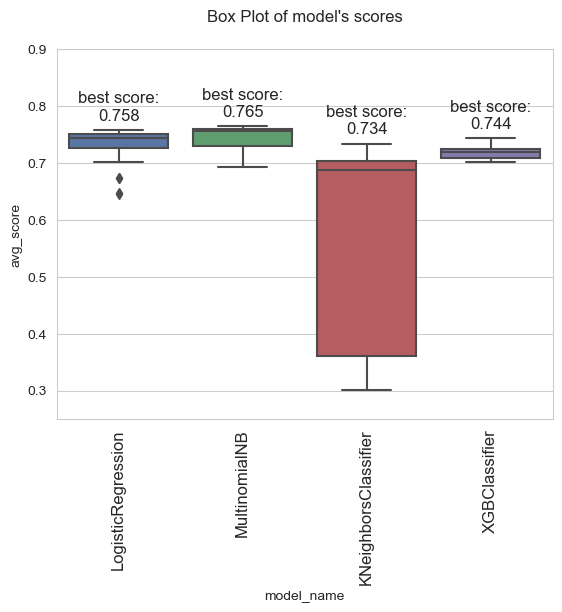

In [78]:
sns.boxplot(data=db_results, x='model_name', y='avg_score', linewidth=1.5)
plt.xticks(rotation=90, fontsize=12)
plt.ylim(0.25,0.90)

max_scores = db_results.groupby('model_name')['avg_score'].max()

for i, model in enumerate(db_results['model_name'].unique()):
    max_score = max_scores[model]
    plt.text(i, max_score+0.04, f'best score:\n{max_score:.3f}', ha='center', va='center', fontsize=12)

plt.title("Box Plot of model's scores", pad=20)
plt.show()

__In general, LogisticRegression and MultinomialNB seem to produce best results. Models other than KNeighborsClassifier give quite consitent results. KNeighborsClassifier has best score similar to other models but it varies significantly. Let's check it in details.__

In [79]:
knn_results = db_results[db_results['model_name']=='KNeighborsClassifier']

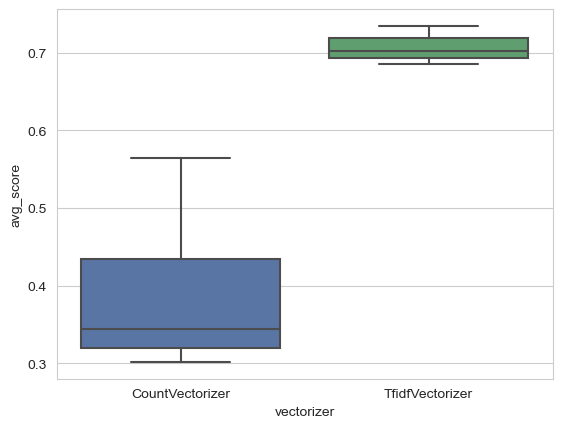

In [80]:
sns.boxplot(data=knn_results, x='vectorizer', y='avg_score', linewidth=1.5)
plt.show()

__As shown on plot above KNeighborsClassifier works well only with Tfidf Vectorizer. Let's take a closer look if it's the case for other models.__

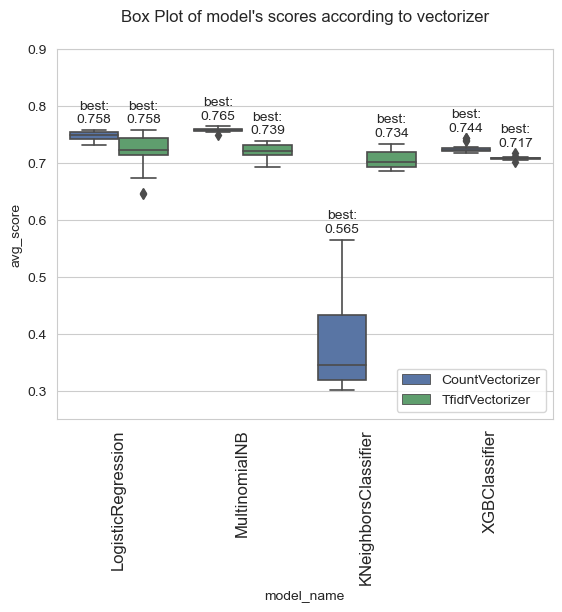

In [81]:
sns.boxplot(data=db_results, x='model_name', y='avg_score', hue='vectorizer', linewidth=1.2)
plt.xticks(rotation=90, fontsize=12)
plt.ylim(0.25,0.90)

max_scores = db_results.groupby(['model_name', 'vectorizer'])['avg_score'].max()

for i, model in enumerate(db_results['model_name'].unique()):
    for j, vectorizer in enumerate(db_results['vectorizer'].unique()):
        max_score = max_scores[model, vectorizer]
        plt.text(i-0.2+j*0.4, max_score+0.03, f'best:\n{max_score:.3f}', ha='center', va='center', fontsize=10)

plt.title("Box Plot of model's scores according to vectorizer", pad=20)
plt.legend(loc='lower right')
plt.show()

__In case of other models we can see inverse relationship (CountVectorizer does better), but to a much lesser extent.__

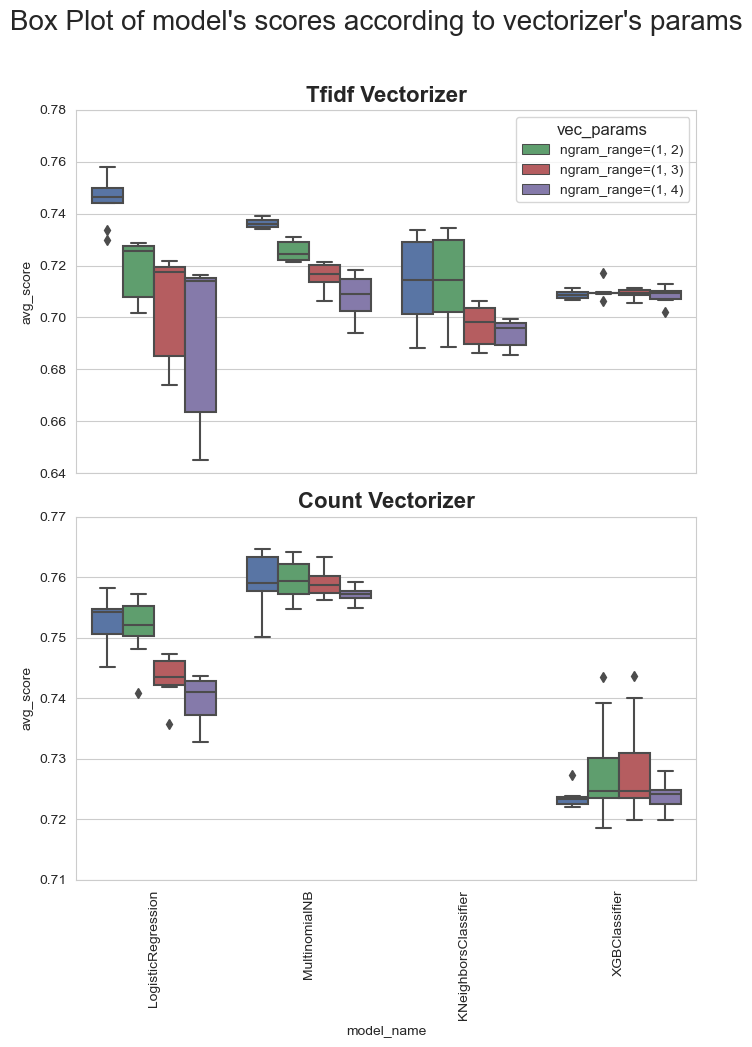

In [82]:
fig, ax = plt.subplots(2,1, figsize=(8,10), sharex=True)

sns.boxplot(
    data=db_results[db_results['vectorizer']=='TfidfVectorizer'], 
    x='model_name', y='avg_score', hue='vec_params', linewidth=1.5, ax=ax[0]
)

sns.boxplot(
    data=db_results[db_results['vectorizer']=='CountVectorizer'], 
    x='model_name', y='avg_score', hue='vec_params', linewidth=1.5, ax=ax[1]
)

ax[0].set_title('Tfidf Vectorizer', fontsize=16, weight='bold')
ax[0].set_xlabel(None)
ax[0].set_ylim(0.64,0.78)
ax[0].legend(loc='upper right').set_title('vec_params', prop={'size': 12})

ax[1].set_title('Count Vectorizer', fontsize=16, weight='bold')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylim(0.71,0.77)
ax[1].get_legend().remove()

plt.suptitle("Box Plot of model's scores according to vectorizer's params", fontsize=20)
plt.subplots_adjust(hspace=0.12)
plt.show()

__Conclusions (for more accurate vectorizer: KNN - Tfidf, rest - CountVectorizer):__

__- KNN - best results without n-grams and ngram_range=(1,2), other ngrams_range give worse results.__

__- Logistic Regression and MNB - f1 score drops while adding more ngram_range.__

__- XGB - quite consistents results, slighlty worse without setting ngram parameter.__

__In next chart we will operate on dataset without cases of CountVectorizer with KNN because it biases results a lot.__

In [83]:
db_results_mod = db_results[
    ~((db_results['vectorizer']=='CountVectorizer') & (db_results['model_name']=='KNeighborsClassifier'))
]

In [84]:
db_results_mod.head(2)

,date,model_name,model_id,models_params,best_score,avg_score,test_score,vectorizer,vec_params,vectorizer_id,features,number_features
0,2023-12-27,LogisticRegression,1,,0.7570,0.7451,NaN,CountVectorizer,,1,text_processed,1
1,2023-12-27,MultinomialNB,2,,0.7627,0.7550,NaN,CountVectorizer,,1,text_processed,1


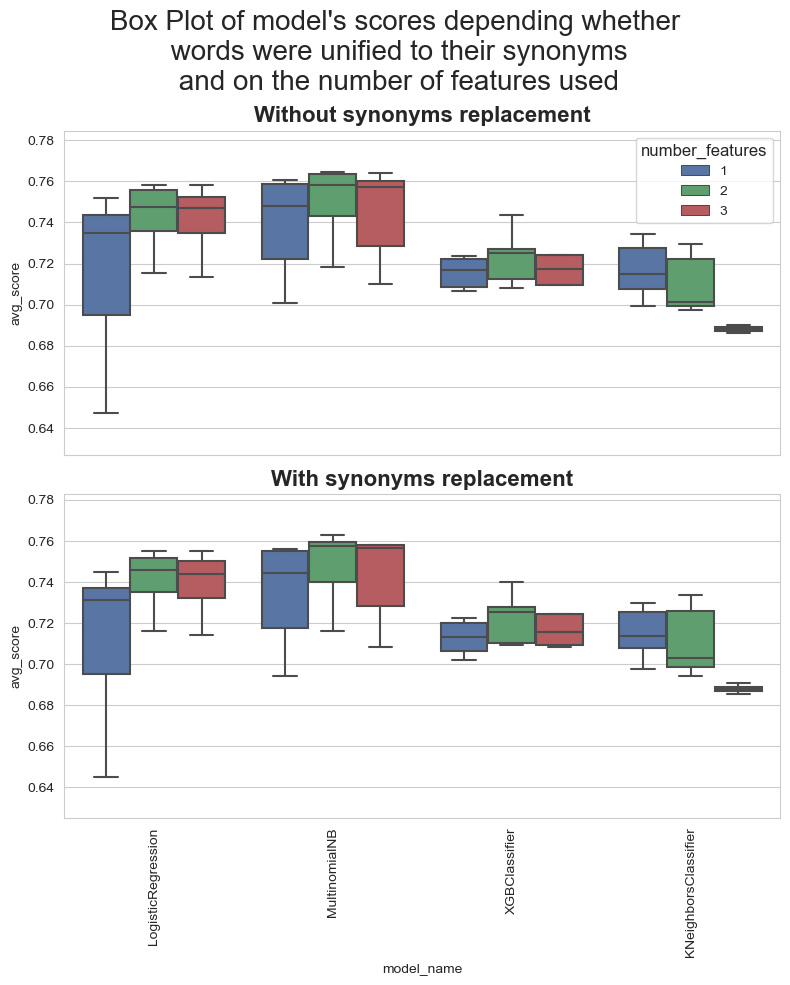

In [85]:
results_no_syn = db_results_mod[db_results_mod['features'].str.contains('text_processed_no_syn')]
results_syn = db_results_mod[~db_results_mod['features'].str.contains('text_processed_no_syn')]

fig, ax = plt.subplots(2,1, figsize=(8,10), sharex=True)

sns.boxplot(
    data=results_no_syn, 
    x='model_name', y='avg_score', hue='number_features', linewidth=1.5, ax=ax[0]
)

sns.boxplot(
    data=results_syn, 
    x='model_name', y='avg_score', hue='number_features', linewidth=1.5, ax=ax[1]
)

ax[0].set_title('Without synonyms replacement', fontsize=16, weight='bold')
ax[0].set_xlabel(None)
ax[0].set_ylim(results_no_syn['avg_score'].min()-0.02, results_no_syn['avg_score'].max()+0.02)
ax[0].legend(loc='upper right').set_title('number_features', prop={'size': 12})

ax[1].set_title('With synonyms replacement', fontsize=16, weight='bold')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylim(results_syn['avg_score'].min()-0.02, results_syn['avg_score'].max()+0.02)
ax[1].get_legend().remove()

plt.suptitle(
    "Box Plot of model's scores depending whether\n words were unified to their synonyms\n and on the number of features used"
    , fontsize=20)

plt.subplots_adjust(hspace=0.12)
plt.tight_layout()
plt.show()

__Dataset without synonyms replacement seems to give slightly better results in all cases. In general, 2 features (text, keyword) are best choice.__

## Hypertuning

__Now, as we know which features and vectorizers work best for different models, let's try to hypertune parameters of the models to increase scores.__

__In order to do that we will use Randomized Search.__

__Let's prepare functions.__

In [86]:
# Function that performs RandomizedSearchCV and returns results DataFrame compatible with feature_vec_selection

def hyperparameters(estimator, params, X, y, n_iter):
    
    results_list = []
    
    print(f'Randomized Searching {str(estimator)} in progress...\n')
               
    model = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    scoring='f1',
    cv=kf,
    n_jobs=-1,
    n_iter=n_iter
)
    model.fit(X,y)

    avg_score = model.best_score_
    best_model = model.best_estimator_

    new = {'model' : best_model,
           'best_score' : 0,                        
           'avg_score' : round(avg_score,4),
           'time' : 0}

    results_list.append(new)


    print(f'model: {str(best_model)}, best F1-score: {round(avg_score,4)}')
            
    print('')

    return pd.DataFrame(results_list)

### MultinomialNB

In [122]:
estimator = MultinomialNB()
params = {'alpha' : scipy.stats.loguniform(0.1,10)}
feature_selection = [
    ['text_processed_no_syn', 'keyword_processed', 'location_processed'],
    ['text_processed', 'keyword_processed', 'location_processed'],
    ['text_processed_no_syn', 'keyword_processed'],
    ['text_processed', 'keyword_processed'],
    ['text_processed_no_syn', 'location_processed'],
    ['text_processed', 'location_processed']
]
vectorizers = [
    CountVectorizer(),
    CountVectorizer(ngram_range=(1, 2)),
    CountVectorizer(ngram_range=(1, 3))
]

In [123]:
# !!! If you operate in 'hyperparameters' mode, put model (NOT A LIST!) as parameter 'models' 

# mnb_hyper_results = feature_vec_selection(df_train, feature_selection, vectorizers, 
#                                           mode='hyperparameters', models=estimator, params=params)

!!! START!!!

6 sets of features
3 vectorizers
This gives us 18 iterations

-------------------------------------------------------
1/6 Current Feature selection: ['text_processed_no_syn', 'keyword_processed', 'location_processed']
1/3 Current Vectorizer: CountVectorizer()

Randomized Searching MultinomialNB() in progress...

model: MultinomialNB(alpha=0.9792043340198827), best F1-score: 0.7638

-------------------------------------------------------

1/6 Current Feature selection: ['text_processed_no_syn', 'keyword_processed', 'location_processed']
2/3 Current Vectorizer: CountVectorizer(ngram_range=(1, 2))

Randomized Searching MultinomialNB() in progress...

model: MultinomialNB(alpha=1.8872323100746329), best F1-score: 0.7603

-------------------------------------------------------

1/6 Current Feature selection: ['text_processed_no_syn', 'keyword_processed', 'location_processed']
3/3 Current Vectorizer: CountVectorizer(ngram_range=(1, 3))

Randomized Searching MultinomialNB() in p

In [90]:
# add_results_to_db(mnb_hyper_results)

In [91]:
db_results[db_results['model_name']=='MultinomialNB'].sort_values(by='avg_score', ascending=False).head(5)

,date,model_name,model_id,models_params,best_score,avg_score,test_score,vectorizer,vec_params,vectorizer_id,features,number_features
198,2024-01-02,MultinomialNB,199,alpha=0.7800287013415748,0.0000,0.7646,0.79344,CountVectorizer,,55,"text_processed_no_syn, keyword_processed",2
199,2024-01-02,MultinomialNB,200,alpha=1.6637221458567735,0.0000,0.7641,0.80447,CountVectorizer,"ngram_range=(1, 2)",56,"text_processed_no_syn, keyword_processed",2
192,2024-01-02,MultinomialNB,193,alpha=0.9871464088346832,0.0000,0.7639,0.79252,CountVectorizer,,49,"text_processed_no_syn, keyword_processed, loca...",3
133,2023-12-27,MultinomialNB,134,,0.7784,0.7637,0.79711,CountVectorizer,"ngram_range=(1, 2)",34,"text_processed_no_syn, keyword_processed",2
161,2023-12-27,MultinomialNB,162,,0.7815,0.7636,0.79037,CountVectorizer,,41,"text_processed_no_syn, keyword_processed, loca...",3


### Logistic Regression

In [92]:
estimator = LogisticRegression()

params = {'solver' : ['liblinear', 'saga'],
          'penalty' : ['l2', None],
          'C' : scipy.stats.loguniform(0.001,10),
          'max_iter' : scipy.stats.randint(100,500)}

feature_selection = [
    ['text_processed_no_syn', 'keyword_processed', 'location_processed'],
    ['text_processed', 'keyword_processed', 'location_processed'],
    ['text_processed_no_syn', 'keyword_processed'],
    ['text_processed', 'keyword_processed'],
]

vectorizers = [
    TfidfVectorizer(),
    CountVectorizer(),
    CountVectorizer(ngram_range=(1, 2))
]

In [93]:
# lr_hyper_results = feature_vec_selection(df_train, feature_selection, vectorizers, 
#                                          mode='hyperparameters', models=estimator, params=params)

In [94]:
# add_results_to_db(lr_hyper_results)

In [95]:
db_results[db_results['model_name']=='LogisticRegression'].sort_values(by='avg_score', ascending=False).head(5)

,date,model_name,model_id,models_params,best_score,avg_score,test_score,vectorizer,vec_params,vectorizer_id,features,number_features
217,2024-01-02,LogisticRegression,218,"C=0.4402341520720492, max_iter=284, solver='saga'",0.0,0.7582,0.80202,CountVectorizer,,74,"text_processed_no_syn, keyword_processed",2
211,2024-01-02,LogisticRegression,212,"C=0.38469858870076307, max_iter=337, solver='s...",0.0,0.7580,0.79650,CountVectorizer,,68,"text_processed_no_syn, keyword_processed, loca...",3
216,2024-01-02,LogisticRegression,217,"C=3.0964738492532407, max_iter=109, solver='li...",0.0,0.7579,NaN,TfidfVectorizer,,73,"text_processed_no_syn, keyword_processed",2
218,2024-01-02,LogisticRegression,219,"C=1.2650168556590222, max_iter=128, solver='saga'",0.0,0.7572,NaN,CountVectorizer,"ngram_range=(1, 2)",75,"text_processed_no_syn, keyword_processed",2
212,2024-01-02,LogisticRegression,213,"C=0.7222349239920716, max_iter=197, solver='saga'",0.0,0.7568,NaN,CountVectorizer,"ngram_range=(1, 2)",69,"text_processed_no_syn, keyword_processed, loca...",3


### KNeighborsClassifier

In [97]:
estimator = KNeighborsClassifier()

params = {'weights' : ['uniform', 'distance'],
          'n_neighbors' : scipy.stats.randint(1,200)}

feature_selection = [
    ['text_processed_no_syn', 'keyword_processed'],
    ['text_processed', 'keyword_processed'],
    ['text_processed_no_syn'],
    ['text_processed']
]

vectorizers = [
    TfidfVectorizer(),
    TfidfVectorizer(ngram_range=(1, 2))
]

In [98]:
# knn_hyper_results = feature_vec_selection(df_train, feature_selection, vectorizers, 
#                                           mode='hyperparameters', models=estimator, params=params)

In [99]:
# add_results_to_db(knn_hyper_results)

In [100]:
db_results[db_results['model_name']=='KNeighborsClassifier'].sort_values(by='avg_score', ascending=False).head(5)

,date,model_name,model_id,models_params,best_score,avg_score,test_score,vectorizer,vec_params,vectorizer_id,features,number_features
227,2024-01-02,KNeighborsClassifier,228,"n_neighbors=84, weights='distance'",0.0,0.7344,NaN,TfidfVectorizer,"ngram_range=(1, 2)",84,text_processed_no_syn,1
225,2024-01-02,KNeighborsClassifier,226,"n_neighbors=188, weights='distance'",0.0,0.7339,NaN,TfidfVectorizer,"ngram_range=(1, 2)",82,"text_processed, keyword_processed",2
224,2024-01-02,KNeighborsClassifier,225,"n_neighbors=183, weights='distance'",0.0,0.7338,NaN,TfidfVectorizer,,81,"text_processed, keyword_processed",2
226,2024-01-02,KNeighborsClassifier,227,"n_neighbors=26, weights='distance'",0.0,0.7314,NaN,TfidfVectorizer,,83,text_processed_no_syn,1
229,2024-01-02,KNeighborsClassifier,230,"n_neighbors=62, weights='distance'",0.0,0.7299,NaN,TfidfVectorizer,"ngram_range=(1, 2)",86,text_processed,1


### XGBoost

In [101]:
estimator = XGBClassifier()

params = {
    "n_estimators": scipy.stats.randint(50,200),
    "learning_rate": scipy.stats.loguniform(0.01,1.0),
    "max_depth": scipy.stats.randint(3,10),
    "subsample": scipy.stats.uniform(0.1,1.0),
    "colsample_bynode": scipy.stats.uniform(0.1,1.0),
    "max_leaves" : [3, 5, 10, None]
}

feature_selection = [
    ['text_processed_no_syn', 'keyword_processed'],
    ['text_processed', 'keyword_processed']
]

vectorizers = [
    CountVectorizer(ngram_range=(1, 2)),
    CountVectorizer(ngram_range=(1, 3))
]

In [102]:
# xgb_hyper_results = feature_vec_selection(df_train, feature_selection, vectorizers, 
#                                           mode='hyperparameters', models=estimator, params=params)

In [103]:
# add_results_to_db(xgb_hyper_results)

In [104]:
db_results[db_results['model_name']=='XGBClassifier'].sort_values(by='avg_score', ascending=False).head(5)

,date,model_name,model_id,models_params,best_score,avg_score,test_score,vectorizer,vec_params,vectorizer_id,features,number_features
231,2024-01-02,XGBClassifier,232,"base_score=None, booster=None, callbacks=None,...",0.0000,0.7436,0.78731,CountVectorizer,"ngram_range=(1, 3)",88,"text_processed_no_syn, keyword_processed",2
230,2024-01-02,XGBClassifier,231,"base_score=None, booster=None, callbacks=None,...",0.0000,0.7435,0.78669,CountVectorizer,"ngram_range=(1, 2)",87,"text_processed_no_syn, keyword_processed",2
233,2024-01-02,XGBClassifier,234,"base_score=None, booster=None, callbacks=None,...",0.0000,0.7400,0.78792,CountVectorizer,"ngram_range=(1, 3)",90,"text_processed, keyword_processed",2
232,2024-01-02,XGBClassifier,233,"base_score=None, booster=None, callbacks=None,...",0.0000,0.7392,0.79221,CountVectorizer,"ngram_range=(1, 2)",89,"text_processed, keyword_processed",2
47,2023-12-27,XGBClassifier,48,"base_score=None, booster=None, callbacks=None,...",0.7473,0.7280,0.77965,CountVectorizer,"ngram_range=(1, 4)",12,"text_processed, keyword_processed",2


__We can see increase in scores, in case of every model above, after adjusting hyperparamteres.__

## Results

__Let's take a look at best results for every model.__ 

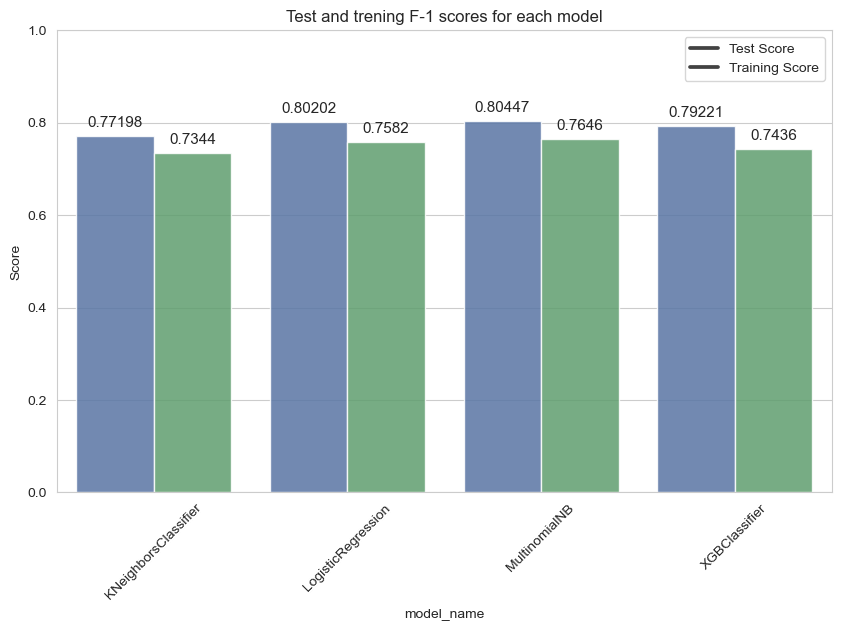

In [106]:
best_results = db_results.groupby('model_name')[['test_score', 'avg_score']].max().reset_index()\
                         .melt(id_vars='model_name', value_vars=['test_score', 'avg_score'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='model_name', y='value', hue='variable', data=best_results, alpha=0.85)
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.title('Test and trening F-1 scores for each model')
plt.legend(labels=['Test Score','Training Score'])
plt.ylim(0,1)

best_results_sorted = best_results.sort_values(by=['variable', 'model_name'], ascending=[False, True])['value']

for patch, score in zip(ax.patches, best_results_sorted):
    plt.text(x=patch.get_x()+ax.patches[0].get_width()/2, y=patch.get_height()+0.02, s=score, ha='center', fontsize=11)

plt.show()

__Similary to validation scores, best scores on training set was achieved by MNB followed by Logistic Regression. What's interesting our test scores were clearly better in every case.__

### VotingClassifier

__Last thing we will try is to make an ensemble of best models so far. I would like to try something like VotingClassifier from sklearn library. However it requires that all estimators make predictions on identical datasets. In our case, different models work best using different vectorizers and sets of features. Therefore we will create classifier that makes predictions based on the majority of 'votes'.__

In [ ]:
# function needs training dataset and model ids as parameters in it's basic version 
# (which only calculate scores on training set)
# If we want to make predictions on test set and create submission file we need to 
# input also test dataset and change parameter submission to True

def voting(df_train, models_ids, submission=False, df_test=None):
    
    db_results = db_to_df()
    to_submit = db_results[db_results['model_id'].isin(models_ids)]
    # converting features to list 
    to_submit['features'] = to_submit['features'].apply(lambda x: x.replace(" ", "").split(","))
    
    y = df_train['target']
    voting_results = pd.DataFrame()
    voting_results_test = pd.DataFrame()
    
    
    for model_id in models_ids:
        
        vectorizer_id = db_results[db_results['model_id']==model_id]['vectorizer_id'].iloc[0]
        
        # uploading model from pickle file
        model = pickle.load(open('models/' + str(model_id), 'rb'))
        features = to_submit[to_submit['model_id']==model_id]['features'].iloc[0]
        # uploading vectorizer from pickle file
        vectorizers = pickle.load(open('vectorizers/' + str(vectorizer_id), 'rb'))
        
        # vectorization test set with vectorizer fitted on appropriate train set
        X_vectorized, _ = concat_vectorize(df_train, features, vectorizers, 'test')
        # making prediction
        y_pred = model.predict(X_vectorized)
        
        # saving predictions to DataFrame
        voting_results[str(model_id)] = y_pred
        
        print(f'F1 score of model {str(model_id)}: {f1_score(y, y_pred)}')
        
        # additional functionality - performing prediction on test set
        if submission:
            X_test_vectorized, _ = concat_vectorize(df_test, features, vectorizers, 'test')
            y_pred_test = model.predict(X_test_vectorized)
            voting_results_test[str(model_id)] = y_pred_test
    
    # performing majority voting process
    voting_results['voting_prediction'] = voting_results.mean(axis=1).apply(lambda row: int(round(row,0)))
    voting_pred = np.array(voting_results['voting_prediction'])
    
    print(f'\nF1 score for voting: {f1_score(y, voting_pred)}')

    # additional functionality - voting and creating submission
    if submission:
        
        voting_results_test['voting_prediction'] = voting_results_test.mean(axis=1).apply(lambda row: int(round(row,0)))
        voting_pred_test = np.array(voting_results_test['voting_prediction'])
        
        filename = str(date.today()) + '_voting_models_' + '_'.join([str(model) for model in models_ids])
        
        submission_file(df_test, voting_pred_test, filename)
        
        print(f'\nSubmission file for Voting Model prepared')
      
    return voting_results, voting_pred

__First, let's try to use the best models of every kind (except KNN becasue it performed poorest and we prefer the odd number of voters.__

In [109]:
best_models = db_results.loc[db_results.groupby('model_name')['test_score'].idxmax()]['model_id'][1:].to_list()
best_models

[218, 200, 233]

In [156]:
voting_results, voting_pred = voting(df_train, best_models)

F1 score of model 218: 0.9060402684563759
F1 score of model 200: 0.9337283642600966
F1 score of model 233: 0.8325390304026294

F1 score for voting: 0.9098452209988831


__We can see that scores in this case are much higher than before. It is probably caused by fact that previous scores were achieved on validation set and these are calculated on training set on which the models were trained. Prediction from voting doesn't have better score than best model but models might overfit on this data and we might expect that voting classifier generalizes better to test set. Let's check it!__

In [147]:
voting_results, voting_pred = voting(df_train, best_models, submission=True, df_test=df_test)

F1 score of model 218: 0.9060402684563759
F1 score of model 200: 0.9337283642600966
F1 score of model 233: 0.8325390304026294

F1 score for voting: 0.9098452209988831

Submission file for Voting Model prepared


__It turns out that our Voting Classifier indeed reached the highest score so far: 0.80907 !!!__

__Our best prediction ranks around place 320th out of over 1000 and performs better than Kaggle's AutoML Benchmark!__

__There are many more adjustments we could try, including:__
- improve data cleaning,
- try different sets of features (new features like tweet length etc.),
- check more parameteres of models and vectorizers,
- try other models especially Neural Networks of different architectures.